### Data source: 
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge


## Importing relevant libraries and load the data

In [ ]:

!pip install nltk

In [ ]:
# Import relevant packages
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  # Remove useless words
from nltk.stem.lancaster import LancasterStemmer  # Convert words to base form; aggressive

# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [ ]:
# In case there is a bug, just download stopwords again.
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Stopwords are a list of 'useless' words
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## Load the CSV and take a peek at 1st 5 rows

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PROJECTS/pbl/PBLproject/mlmodel/toxic_comments_classifier/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Entries with all 0 under the 6 categories are neutral and considered as non-toxic.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


A clean dataset with no missing values. Sweet!

## Let's see how the 1st 3 comments look like

In [ ]:
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
data['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [ ]:
data['comment_text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

The comments are dirty with '\n' values, symbols, numbers that will not be useful for analysis. We will be removing these further down the pipeline.

## Exploratory Data Analysis

In [ ]:
# Check percentage of comments that are toxic compared to normal comments
data.toxic.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

Cool. It seems that 90% of the comments fall in the toxic category.

In [ ]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=data.iloc[:,2:].sum()

In [ ]:
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


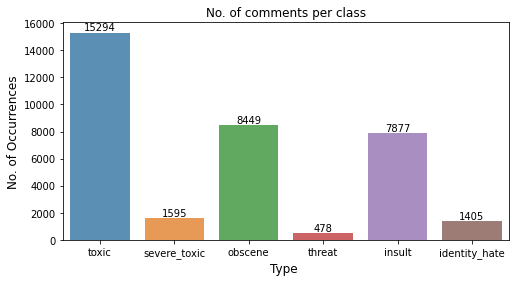

In [ ]:
# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category. alpha = 0.8 to make the bars more translucent
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels for each bar
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
num_rows = len(data)
print(num_rows)

159571


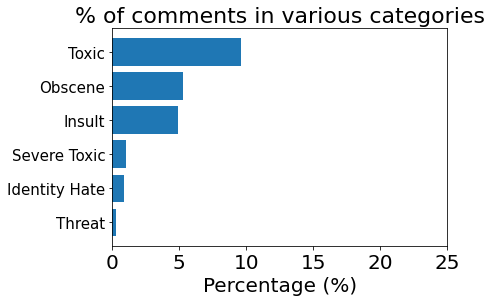

In [ ]:
# Create a bar graph 
sum_tox = data['toxic'].sum() / num_rows * 100
sum_sev = data['severe_toxic'].sum() / num_rows * 100
sum_obs = data['obscene'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_ins = data['insult'].sum() / num_rows * 100
sum_ide = data['identity_hate'].sum() / num_rows * 100

# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()


## Preprocess the text

In [ ]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

## Separate our dataset into 6 sections. Each section is comment + 1 category.

In [ ]:
data_tox = data.loc[:,['id','comment_text','toxic']]

In [ ]:
data_tox['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [ ]:
data_tox['comment_text'][1]

'd aww  he matches this background colour i m seemingly stuck with  thanks    talk       january       utc '

In [ ]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]

In [ ]:
data_obs = data.loc[:,['id','comment_text','obscene']]

In [ ]:
data_thr = data.loc[:,['id','comment_text','threat']]

In [ ]:
data_ins = data.loc[:,['id','comment_text','insult']]

In [ ]:
data_ide = data.loc[:,['id','comment_text','identity_hate']]

## Creating WordCloud
### Useful to show the words which occur most frequently for each category. Warning: Profanity ahead.

In [ ]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [ ]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

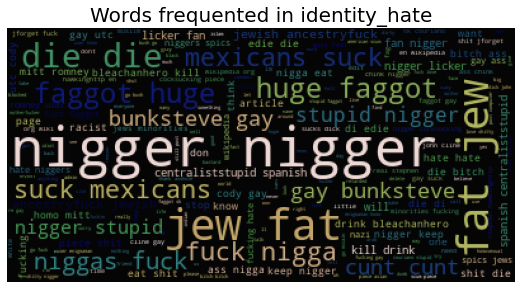

In [ ]:
wordcloud(data_ide,'identity_hate')

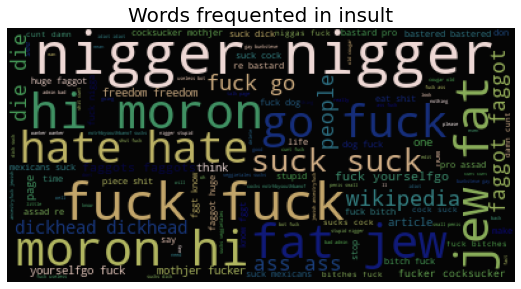

In [ ]:
wordcloud(data_ins, 'insult')

#### Earlier, we saw that comments that are toxic (and other forms of toxicity) make up less than 10% of the comments in the data. This leads to the issue of class imbalance.

#### We can deal with class imbalance by taking a subset of the data where the proportion of the toxic comments are at least 20% (ideally 50%) in relation to non-toxic comments.

#### For a start, we can take 5000 rows of comments that are toxic and concatenate them row-wise with those that are not toxic so that we have a balanced dataset.

In [ ]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [ ]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [ ]:
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

In [ ]:
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(10000, 3)

### Not all categories have 5000 rows. So we should count them first and make them balanced.

In [ ]:
data_sev[data_sev['severe_toxic'] == 1].count()


id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [ ]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3190, 3)

Cool. We only had 1,595 comments that are severely toxic. We combine it together with another 1,595 comments that are not toxic to form a new dataset that is balanced. We repeat this for all other categories.

In [ ]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [ ]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(10000, 3)

In [ ]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

The number of threat comments of 478 is too miniscule when addded with another 478 clean comments for a proper analysis. We decided that the clean comments will comprise 80% at the most of the dataset, as shown below.

In [ ]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [ ]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [ ]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(10000, 3)

In [ ]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [ ]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(7025, 3)

Reminder: Number of comments that fall into the following categories:

- Toxic (14,000+) 
- Severe Toxic (1595)
- Obscene (8449)
- Threat (478)
- Insult (7877)
- Identity Hate (1405)

#### df_****_done refers to the dataframes of each class that has been balanced (at least 20/80 proportion)

|                      | DF name       | No. of pts (1) | No. of pts (0) | Total data pts |
|----------------------|---------------|----------------|----------------|----------------|
| Toxic                | data_tox_done | 5000           | 5000           | 10000          |
| Severe Toxic         | data_sev_done | 1595           | 1595           | 3190           |
| Obscene (8449)       | data_obs_done | 5000           | 5000           | 10000          |
| Threat (478)         | data_thr_done | 478            | 1912           | 2390           |
| Insult (7877)        | data_ins_done | 5000           | 5000           | 10000          |
| Identity Hate (1405) | data_ide_done | 1405           | 5620           | 7025           |

### Import relevant packages for modelling

In [ ]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


### Create simple function that takes in a dataset and allows user to choose dataset, toxicity label, vectorizer and number of ngrams

In [ ]:
'''
df_done: data_tox_done, data_sev_done, ...
label: toxic, severe_toxic, ...
vectorizer values: CountVectorizer, TfidfVectorizer
gram_range values: (1,1) for unigram, (2,2) for bigram
'''
def cv_tf_train_test(df_done,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1


### Let's create a TF-IDF vectorizer object for each category and calculate the F1 scores across all models

In [ ]:
'''
def cv_tf_train_test(df_done,label,vectorizer,ngram)
vectorizer values: CountVectorizer, TfidfVectorizer
ngram_range values: (1,1) for unigram, (2,2) for bigram
'''

import time

t0 = time.time()

df_tox_cv = cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

# Various permutations of the dataset, category, vectorizer and n-gram

# cv_tf_train_test(data_tox_done, 'toxic', CountVectorizer, (1,1))
# cv_tf_train_test(data_sev_done, 'severe_toxic', CountVectorizer, (1,1))
# cv_tf_train_test(data_obs_done, 'obscene', CountVectorizer, (1,1))
# cv_tf_train_test(data_thr_done, 'threat', CountVectorizer, (1,1))
# cv_tf_train_test(data_ins_done, 'insult', CountVectorizer, (1,1))
# cv_tf_train_test(data_ide_done, 'identity_hate', CountVectorizer, (1,1))

# cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))


lr done
bnb done
mnb done
rdf done
Time taken: 10.975812196731567 seconds


,F1 Score(toxic)
Log Regression,0.860846
KNN,0.199301
BernoulliNB,0.776521
MultinomialNB,0.874581
SVM,0.876133
Random Forest,0.839532


In [ ]:

t0 = time.time()

df_sev_cv = cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

lr done
bnb done
mnb done
rdf done
Time taken: 1.995708703994751 seconds


,F1 Score(severe_toxic)
Log Regression,0.927879
KNN,0.856597
BernoulliNB,0.803707
MultinomialNB,0.936170
SVM,0.926004
Random Forest,0.940563


In [ ]:

t0 = time.time()

df_obs_cv = cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

lr done
bnb done
mnb done
rdf done
Time taken: 10.111711263656616 seconds


,F1 Score(obscene)
Log Regression,0.908655
KNN,0.519196
BernoulliNB,0.787830
MultinomialNB,0.901757
SVM,0.921739
Random Forest,0.912021


In [ ]:

t0 = time.time()

df_thr_cv = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

lr done
bnb done
mnb done
rdf done
Time taken: 1.3822948932647705 seconds


,F1 Score(threat)
Log Regression,0.628821
KNN,0.720000
BernoulliNB,0.311828
MultinomialNB,0.504762
SVM,0.791209
Random Forest,0.792593


In [ ]:

t0 = time.time()

df_ins_cv = cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv

lr done
bnb done
mnb done
rdf done
Time taken: 10.122664213180542 seconds


,F1 Score(insult)
Log Regression,0.896599
KNN,0.256612
BernoulliNB,0.783762
MultinomialNB,0.896755
SVM,0.901882
Random Forest,0.883689


In [ ]:

t0 = time.time()

df_ide_cv = cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

lr done
bnb done
mnb done
rdf done
Time taken: 5.720024347305298 seconds


,F1 Score(identity_hate)
Log Regression,0.699029
KNN,0.222222
BernoulliNB,0.549206
MultinomialNB,0.483333
SVM,0.795031
Random Forest,0.784558


In [ ]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all


,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
Log Regression,0.860846,0.927879,0.908655,0.896599,0.628821,0.699029
KNN,0.199301,0.856597,0.519196,0.256612,0.720000,0.222222
BernoulliNB,0.776521,0.803707,0.787830,0.783762,0.311828,0.549206
MultinomialNB,0.874581,0.936170,0.901757,0.896755,0.504762,0.483333
SVM,0.876133,0.926004,0.921739,0.901882,0.791209,0.795031
Random Forest,0.839532,0.940563,0.912021,0.883689,0.792593,0.784558


### Transpose the combined F1 dataframe to make it suitable for presentation on a graph

In [ ]:
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.860846,0.199301,0.776521,0.874581,0.876133,0.839532
F1 Score(severe_toxic),0.927879,0.856597,0.803707,0.936170,0.926004,0.940563
F1 Score(obscene),0.908655,0.519196,0.787830,0.901757,0.921739,0.912021
F1 Score(insult),0.896599,0.256612,0.783762,0.896755,0.901882,0.883689
F1 Score(threat),0.628821,0.720000,0.311828,0.504762,0.791209,0.792593
F1 Score(identity_hate),0.699029,0.222222,0.549206,0.483333,0.795031,0.784558


In [ ]:
# sns.lineplot(data=f1_all_trp, markers=True)
# plt.xticks(rotation='90', fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(loc='best')
# plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)


LinearSVC and Random Forest models perform best (purple and brown lines seem to be the highest).

### Test if our code actually works. Probability of the comment falling in various categories should be output.

In [ ]:
data_tox_done.head()

,id,comment_text,toxic
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
12,0005c987bdfc9d4b,hey what is it talk what is it a...,1
16,0007e25b2121310b,bye don t look come or think of comming ba...,1
42,001810bf8c45bf5f,you are gay or antisemmitian archangel whit...,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1


In [ ]:
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)



array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
import requests
import json

def getCreds() :
        """ Get creds required for use in the applications

        Returns:
                dictonary: credentials needed globally
        """

        creds = dict() # dictionary to hold everything
        creds['access_token'] = 'EAAJZA6U84O90BACpCuSeTcLYQtZCaC3W7KGLW25nJYbohSLPNLJYelQnyckFzsDLmqDkZBsdgJKQvMHbKX1yZAGMiA4T0VTDP4LnrqLtZCDZAK2VHiA0rP9pahzvTKSM0ncfZBex7oaSR9vK5nrSSCH1uKKpMRmey9ZCg114rocRz5JEZAQ8mESnr' # access token for use with all api calls
        creds['client_id'] = '661808544758749' # client id from facebook app IG Graph API Test
        creds['client_secret'] = 'd0e2c9fb669b243dffdebcf2ce6d846a' # client secret from facebook app
        creds['graph_domain'] = 'https://graph.facebook.com/' # base domain for api calls
        creds['graph_version'] = 'v8.0' # version of the api we are hitting
        creds['endpoint_base'] = creds['graph_domain'] + creds['graph_version'] + '/' # base endpoint with domain and version
        creds['debug'] = 'no' # debug mode for api call
        creds['page_id'] = '113475840498316' # users page id
        creds['instagram_account_id'] = '17841442320281292' # users instagram account id
        creds['ig_username'] = 'crceprojects' # ig username

        return creds

def makeApiCall( url, endpointParams, debug = 'no' ) :
        """ Request data from endpoint with params

        Args:
                url: string of the url endpoint to make request from
                endpointParams: dictionary keyed by the names of the url parameters
        Returns:
                object: data from the endpoint
        """

        data = requests.get( url, endpointParams ) # make get request

        response = dict() # hold response info
        response['url'] = url # url we are hitting
        response['endpoint_params'] = endpointParams #parameters for the endpoint
        response['endpoint_params_pretty'] = json.dumps( endpointParams, indent = 4 ) # pretty print for cli
        response['json_data'] = json.loads( data.content ) # response data from the api
        response['json_data_pretty'] = json.dumps( response['json_data'], indent = 4 ) # pretty print for cli

        if ( 'yes' == debug ) : # display out response info
                displayApiCallData( response ) # display response

        return response # get and return content

def displayApiCallData( response ) :
        """ Print out to cli response from api call """

        print("\nURL: ") # title
        print(response['url']) # display url hit
        print("\nEndpoint Params: ") # title
        print(response['endpoint_params_pretty']) # display params passed to the endpoint
        print("\nResponse: ") # title
        print(response['json_data_pretty']) # make look pretty for cli
    

In [ ]:
!pip install xlsxwriter
def getUserComment( params, pagingUrl = '' ) :
        """ Get users media

        API Endpoint:
                https://graph.facebook.com/{graph-api-version}/{ig-user-id}/media?fields={fields}&access_token={access-token}
        Returns:
                object: data from the endpoint
        """
        details = dict() # dictionary to hold everything
        details['id'] = '18080099320215174'
        details['caption'] = 'Random Post 1'
        details['media_url'] = 'https://scontent.cdninstagram.com/v/t51.29350-15/120202885_349366736494379_2453927747011417320_n.jpg?_nc_cat=107&_nc_sid=8ae9d6&_nc_ohc=tZEfp7653w0AX-7aRfi&_nc_ht=scontent.cdninstagram.com&oh=a9ba982cc1717b6e93cbca8bced9f018&oe=5F9A6331'
        details['permalink'] = 'https://www.instagram.com/p/CFrzrYYH5_Y/'
        details['media_type'] = 'IMAGE'

        endpointParams = dict() # parameter to send to the endpoint
        endpointParams['fields'] = 'id,caption,media_type,media_url,permalink,thumbnail_url,timestamp,username,comments_count,text,like_count' # fields to get back
        endpointParams['access_token'] = params['access_token'] # access token

        if ( '' == pagingUrl ) : # get first page
                url = params['endpoint_base'] + details['id'] + '/comments' # endpoint url
        else : # get specific page
                url = pagingUrl  # endpoint url

        return makeApiCall( url, endpointParams, params['debug'] ) # make the api call

params = getCreds() # get creds
params['debug'] = 'no' # set debug
response = getUserComment( params ) # get users media from the api

# WRITING COMMENTS AND COMMENT_IDS IN XLSC FILE

import xlsxwriter
workbook = xlsxwriter.Workbook('/content/drive/MyDrive/PROJECTS/pbl/PBLproject/mlmodel/toxic_comments_classifier/projectComments.xlsx')
worksheet = workbook.add_worksheet()
worksheet.write('A1', 'Comment_id')
worksheet.write('B1', 'Comment')

row = 1
col = 0

for comment in response['json_data']['data'] :
        worksheet.write(row, col, comment['id'])
        worksheet.write(row, col + 1, comment['text'])
        row+=1
        print("\nComment id: ", comment['id'])
        # print("User: ", comment['username'])
        print("Comment : " , comment['text'])
workbook.close()
params['debug'] = 'no' # set debug







# DELETE(18055919893280770)



# FB.api(
#     "/{comment-id}",
#     "DELETE",
#     function (response) {
#       if (response && !response.error) {
#         /* handle the result */
#       }
#     }
# );



Comment id:  17897482475006416
Comment :  piece of shit

Comment id:  17972771596331222
Comment :  Test

Comment id:  17881180681963175
Comment :  Testing.....

Comment id:  18042830587279578
Comment :  hii

Comment id:  17854858733309749
Comment :  random comment

Comment id:  17892314977687496
Comment :  test

Comment id:  18032014252304549
Comment :  hii

Comment id:  18132569788191369
Comment :  Test comment

Comment id:  18047453086270448
Comment :  Along with comment ID

Comment id:  17967588631329531
Comment :  Helloo

Comment id:  17872215490925589
Comment :  Gwyown

Comment id:  18080594884209886
Comment :  Comment3

Comment id:  17916711079475529
Comment :  Comment2


In [ ]:
#Loading fetched comments from excel file and merging columns in dictionary

data = pd.read_excel('/content/drive/MyDrive/PROJECTS/pbl/PBLproject/mlmodel/toxic_comments_classifier/projectComments.xlsx')
# data.head()

# print(data.columns)

commentID = data['Comment_id']
comment = data['Comment']


data_dict = dict(zip(commentID, comment))

print(data_dict)

{17897482475006416: 'piece of shit', 17972771596331222: 'Test', 17881180681963175: 'Testing.....', 18042830587279578: 'hii', 17854858733309749: 'random comment', 17892314977687496: 'test', 18032014252304549: 'hii', 18132569788191369: 'Test comment', 18047453086270448: 'Along with comment ID', 17967588631329531: 'Helloo', 17872215490925589: 'Gwyown', 18080594884209886: 'Comment3', 17916711079475529: 'Comment2'}


In [ ]:
#getting result 

for commentID, comment in data_dict.items():
    comment1 = comment
    print(comment1)
    
    comment1_vect = tfv.transform([comment1])
    result = randomforest.predict_proba(comment1_vect)[:,1]
    print("probability: ",result)

    if result > 0.6 :
        toxicComment = comment
        toxicCommentID = commentID
        print("toxic comment ID: ",toxicCommentID)
        print("toxic comment: ",toxicComment,"\n")

    else:
        print("\n")
#     if comment == "Testtt":
#         print(commentID)
    
    
    
# for i in comment:
#     for j in commentID:
#         print(i,j)
#         break

    

# comment1_vect = tfv.transform(comment1)
# result = randomforest.predict_proba(comment1_vect)[:,1]
# print(result)

# if result > 0.9 :
#     print('toxic')

# for i in data.index:
#     print(data['Comment_id'][i])

piece of shit
probability:  [1.]
toxic comment ID:  17897482475006416
toxic comment:  piece of shit 

Test
probability:  [0.26742627]


Testing.....
probability:  [0.28599129]


hii
probability:  [0.27932462]


random comment
probability:  [0.16351573]


test
probability:  [0.26742627]


hii
probability:  [0.27932462]


Test comment
probability:  [0.19254748]


Along with comment ID
probability:  [0.21970774]


Helloo
probability:  [0.27932462]


Gwyown
probability:  [0.27932462]


Comment3
probability:  [0.27932462]


Comment2
probability:  [0.27932462]




In [ ]:



# WRITING COMMENTS AND COMMENT_IDS IN XLSC FILE
!pip install xlsxWriter
import xlsxwriter
workbook = xlsxwriter.Workbook('/content/drive/MyDrive/PROJECTS/pbl/PBLproject/mlmodel/toxic_comments_classifier/toxicComments.xlsx')
worksheet = workbook.add_worksheet()
worksheet.write('A1', 'Comment_id')
worksheet.write('B1', 'Comment')

row = 1
col = 0

print("toxic Comment excel sheet updated!")
worksheet.write(row, col,str(toxicCommentID))
worksheet.write(row, col + 1, toxicComment)
row+=1

workbook.close()


# df = pd.DataFrame({'toxicCommentID':[str(toxicCommentID)],
#                    'toxicComment':[toxicComment]})
# df.to_excel("toxicComments.xlsx")

toxic Comment excel sheet updated!


In [ ]:
# https://graph.facebook.com/v2.8/{comment-id}?method=delete

# from defines import getCreds, makeApiCall
import pandas as pd

data = pd.read_excel('/content/drive/MyDrive/PROJECTS/pbl/PBLproject/mlmodel/toxic_comments_classifier/toxicComments.xlsx')

commentID = data['Comment_id']
comment = data['Comment']
data_dict = dict(zip(commentID, comment))



def getUserComment( params, pagingUrl = '' ) :

        for i in data_dict.keys():
                rmCommentID = i

                comment = dict() # dictionary to hold everything
                comment['id'] = str(rmCommentID)
                print(comment['id'])

        endpointParams = dict() # parameter to send to the endpoint
        endpointParams['fields'] = 'id,caption,media_type,media_url,permalink,thumbnail_url,timestamp,username,comments_count,text,like_count' # fields to get back
        endpointParams['access_token'] = params['access_token'] # access token

        if ( '' == pagingUrl ) :
                url = params['endpoint_base'] + comment['id'] + '?method=delete' # endpoint url
        else : # get specific page
                url = pagingUrl  # endpoint url


        return makeApiCall( url, endpointParams, params['debug'] ) # make the api call




def result(response):
        if response:
                print("comment deleted")
        else:
                print("error occured")

params = getCreds() # get creds
params['debug'] = 'no' # set debug
response = getUserComment( params )
result(response)


17897482475006416
comment deleted


In [ ]:
# Sample Prediction

comment1 = ['dog shit']
comment2 = ['good picture, you piece of shit']
comment2_vect = tfv.transform(comment2)

comment1_vect = tfv.transform(comment1)
result1 = randomforest.predict_proba(comment1_vect)[:,1]
print(result1)

if result1 > 0.9 :
    print('toxic')


[1.]
toxic


In [ ]:
result2 = randomforest.predict_proba(comment2_vect)[:,1]
print(result2)

[0.87]


Random forest has assigned a probability of 1 that comment 1 ('you piece of shit') is toxic. Comment 2 has only a low toxicity probability of 0.42.